# Домашнее задание. Введение в глубокое обучение
соревнование на Kaggle https://www.kaggle.com/competitions/dl2025miptml

# Задание

В рамках данного учебного соревнования вам предстоит построить модель, классифицирующую изображения с одеждой, которая построена на датасете **Fashion-MNIST**.


> **Fashion-MNIST** — аналог знаменитого датасета MNIST, который состоит не из рукописных символов, а из предметов одежды. Он был создан, чтобы актуализировать учебные задачи в компьютерном зрении и приблизить их к реальности.


Решение более сложной постановки этой задачи может использоваться, например, в маркетплейсах. Покупателю могут рекомендоваться товары по изображениям в соответствии с введенным описанием. Продавцу при загрузке изображений в карточку товара могут автоматически рекомендоваться теги и описание предмета одежды.

Каждое изображение представляет собой набор из 784 пикселей (28x28). Каждый пиксель принимает значение от 0 до 255, обозначая его цвет в черно-белой шкале. Обучающая выборка содержит 786 столбцов, где первый (`label`) — принадлежность изображения к классу, а последний — его уникальный номер (`id`). Остальные столбцы — пиксели изображения.

Проведите первичный анализ данных, чтобы определить наличие NaN значений.

Тестовая выборка, на основе которой должно быть получено исследование, содержит все те же столбцы, кроме `label`.

**Расшифровка классов (`label`), к которым принадлежат изображения:**

- `0 T-shirt/top` — футболка;
- `1 Trouser` — брюки;
- `2 Pullover` — свитер;
- `3 Dress` — платье;
- `4 Coat` — пальто;
- `5 Sandal` — сандалия;
- `6 Shirt` — рубашка;
- `7 Sneaker` — кроссовок;
- `8 Bag` — сумка;
- `9 Ankle boot` — сапог.

**Структура данных:**

- `fmnist_train.csv` — обучающая выборка;
- `fmnist_test.csv` — тестовая выборка (на которой должно быть получено предсказание);
- `sample_submission.csv` — пример решения.

### Исходная публикация датасета

Задача будет считаться решенной, если в *Public Leaderboard* вы наберете `score`, который будет равен 0.80 или больше. В качестве метрики используется `accuracy`. В день вы можете отправлять не более 20 решений (это ограничения платформы). Помните, что решения принимаются только в том формате, который представлен в файле `sample_submission.csv`.


### Форма сдачи результата
В качестве результата пришлите скриншот турнирной таблицы и ссылку на блокнот.

In [2]:
! pip install opendatasets

In [13]:
! pip install tensorflow.keras

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/competitions/dl2025miptml'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: anastasiays
Your Kaggle Key: ··········
Extracting archive ./dl2025miptml/dl2025miptml.zip to ./dl2025miptml


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [63]:
train_df = pd.read_csv('./dl2025miptml/fashion-mnist-testn/fmnist_train.csv')
test_df = pd.read_csv('./dl2025miptml/fashion-mnist-testn/fmnist_test.csv')

In [64]:
# Выведем информацию о данных
print("Обучающая выборка:")
print(train_df.head())
print("\n\nТестовая выборка:")
print(test_df.head())

Обучающая выборка:
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel776  pixel777  pixel778  pixel779  pixel780  pixel781  \
0       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
1       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
2       0  ...       0.0       0.0      30.0      43.0       0.0       0.0   
3       0  ...       0.0       0.0       0.0       0.0       1.0       0.0   
4       0  ...       0.0       0.0       0.0       0.0       0.0       0.0   

   pixel782  pixel783  pixel784  Id  
0       0.0      

In [65]:
# Проверяем наличие NaN в обучающей выборке
print("Пропущенные значения в обучающей выборке:")
print(train_df.isna().sum().sum())  # Общее количество NaN

# Проверяем наличие NaN в тестовой выборке
print("\nПропущенные значения в тестовой выборке:")
print(test_df.isna().sum().sum())

Пропущенные значения в обучающей выборке:
424

Пропущенные значения в тестовой выборке:
0


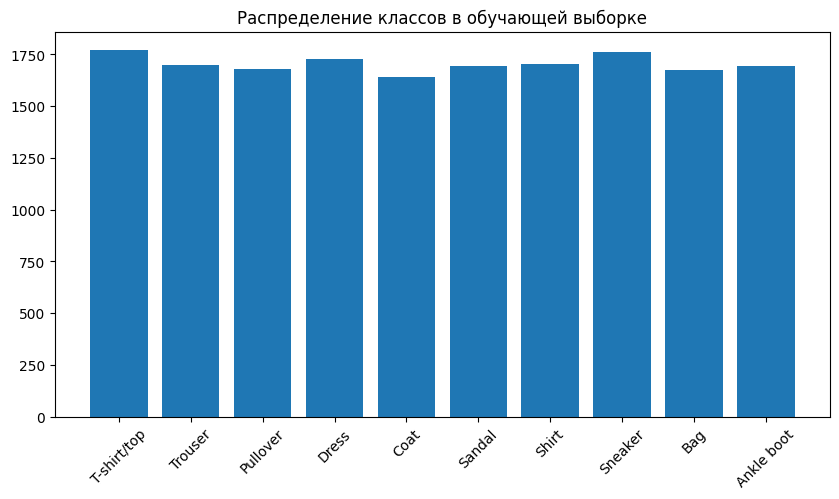

In [66]:
# Распределение меток в обучающей выборке
class_counts = train_df['label'].value_counts().sort_index()
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plt.figure(figsize=(10, 5))
plt.bar(classes, class_counts)
plt.xticks(rotation=45)
plt.title('Распределение классов в обучающей выборке')
plt.show()

Делаем вывод, что явного дисбаланса классов нет

In [67]:
# Используем линейную интерполяцию, чтобы заполнить пропущенные значения
train_df = train_df.interpolate(axis=1)

In [68]:
print("Пропущенные значения в обучающей выборке после интерполяции:")
print(train_df.isna().sum().sum())

Пропущенные значения в обучающей выборке после интерполяции:
0


In [59]:
pixel_columns = train_df.columns[1:785]  # Все колонки с пикселями

In [61]:
pixel_columns

Index(['pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7',
       'pixel8', 'pixel9', 'pixel10',
       ...
       'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780',
       'pixel781', 'pixel782', 'pixel783', 'pixel784'],
      dtype='object', length=784)

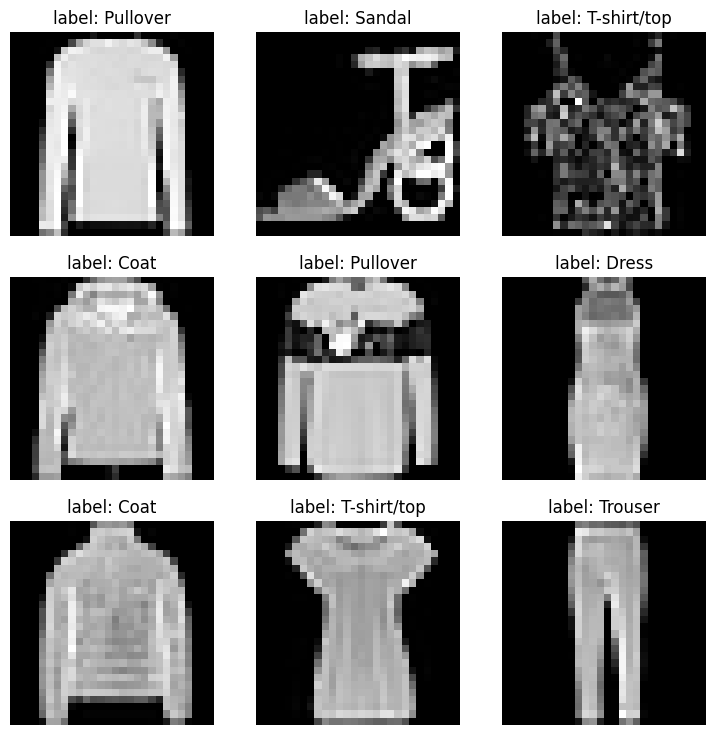

In [69]:
# Выведем несколько случайных элементов выборки
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(train_df))
    img = train_df.iloc[idx, 1:785].values.reshape(28, 28)
    ax.imshow(img, cmap='gray')
    class_label = int(train_df.iloc[idx, 0])
    ax.set_title(f'label: {classes[class_label]}')
    ax.axis('off')
plt.show()

In [73]:
# Выделяем признаки и таргет для модели
# Делим на 255 для нормализации
X = train_df.drop(columns=['label', 'Id']).values / 255.0
y = train_df['label'].values
# Преобразуем в 4D-тензор (N, 28, 28, 1)
X = X.reshape(-1, 28, 28, 1)

In [77]:
# Подготавливаем тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
# Создаем CNN модель

model = Sequential([
    # 1 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), # 32 фильтра 3x3
    BatchNormalization(),  # нормализация
    MaxPooling2D((2,2)),   # уменьшение размерности в 2 раза
    # 2 слой: свертка + BatchNormalization + MaxPooling
    Conv2D(64, (3,3), activation='relu'), # 64 фильтра 3x3
    BatchNormalization(),
    MaxPooling2D((2,2)),

    # Вытягиваем 3D-тензор в 1D вектор
    Flatten(),

    # Полносвязные слои
    # 128 нейронов
    Dense(128, activation='relu'),
    # dropout 50% нейронов для регуляризации
    Dropout(0.5),
    # Выходной слой (10 классов)
    Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [81]:
model.compile(
    optimizer='adam',  # оптимизация Adam
    loss='sparse_categorical_crossentropy',  # Функция потерь для наших целочисленных меток
    metrics=['accuracy']  # метрика для оценки
)

In [88]:
%%time
# Обучаем модель
history = model.fit(X_train, y_train,
                    epochs=15,                      # Макс. число эпох
                    batch_size=64,                  # Размер батчей
                    validation_data=(X_val, y_val)) # Валидационные данные

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 17s 82ms/step - accuracy: 0.9133 - loss: 0.2299 - val_accuracy: 0.8914 - val_loss: 0.3144
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9230 - loss: 0.2029 - val_accuracy: 0.8926 - val_loss: 0.3480
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9318 - loss: 0.1834 - val_accuracy: 0.8911 - val_loss: 0.3345
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.9278 - loss: 0.1880 - val_accuracy: 0.8812 - val_loss: 0.3767
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9365 - loss: 0.1670 - val_accuracy: 0.8870 - val_loss: 0.3591
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 83ms/step - accuracy: 0.9377 - loss: 0.1549 - val_accuracy: 0.8688 - val_loss: 0.4580
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.9422 - loss: 0.1452 - val_accuracy: 0.8982 - val_loss: 0.3510
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 94ms/step - accuracy: 0.9463 - loss: 0.1345 - 

In [83]:
# Подготовим тестовые данные
# Ранее проверяли, что пропусков в тестовой выборке нет

# Удаляем колонку, не относящуюся к пикселям и делаем нормализацию
X_test = test_df.drop(columns=['Id']).values / 255.0
# Преобразуем в 4D-тензор (N, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [89]:
# Предсказание на тестовых данных
y_pred = model.predict(X_test)
pred_classes = np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


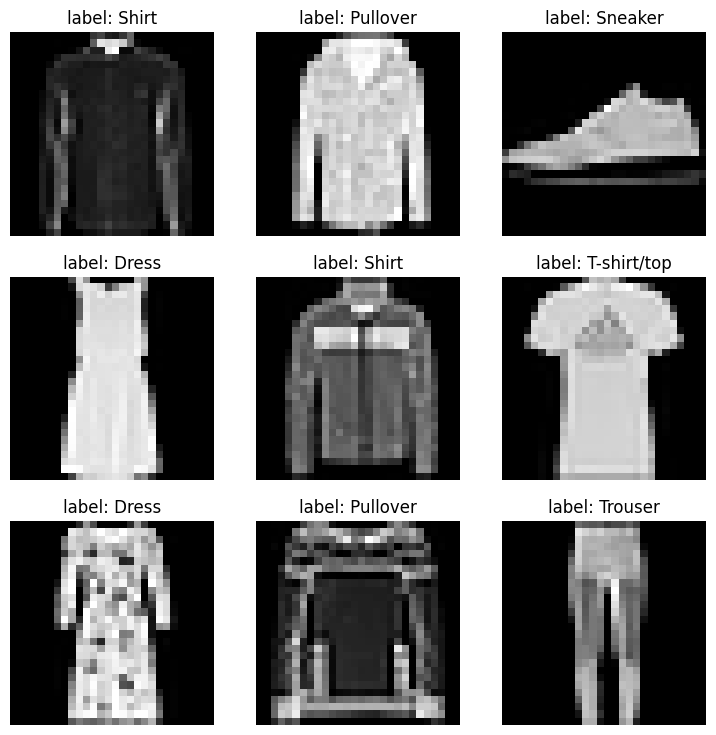

In [90]:
# Выведем несколько случайных элементов выборки
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(X_test))
    img = X_test[idx].reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f'label: {classes[pred_classes[idx]]}')
    ax.axis('off')
plt.show()

In [91]:
# Посмотрим как должен выглядеть файл sample_submission
sample_submission = pd.read_csv('./dl2025miptml/fashion-mnist-testn/sample_submission.csv')
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   label   10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [92]:
# Создаем submission файл
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'label': pred_classes
})

# Сохраняем файл
submission.to_csv('submission.csv', index=False)
print("Файл сохранен")

Файл сохранен


Получилась точность 0.89.  
Для улучшения точности переобучим модель на всем тренировочном наборе данных (X_train + X_val)

In [97]:
print("Оптимальное количество эпох по разным показателям:")
print("По val_loss: ", len(history.history['val_loss']))
print("По loss: ", len(history.history['loss']))
print("По accuracy: ", len(history.history['val_accuracy']))
print("По accuracy: ", len(history.history['accuracy']))

Оптимальное количество эпох по разным показателям:
По val_loss:  15
По loss:  15
По accuracy:  15
По accuracy:  15


In [95]:
model.fit(X, y, epochs=15, batch_size=64)

Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.9326 - loss: 0.2156
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - accuracy: 0.9470 - loss: 0.1480
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 42s 86ms/step - accuracy: 0.9445 - loss: 0.1489
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9514 - loss: 0.1355
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.9574 - loss: 0.1175
Epoch 6/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.9597 - loss: 0.1093
Epoch 7/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 37s 92ms/step - accuracy: 0.9602 - loss: 0.1024
Epoch 8/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.9647 - loss: 0.0931
Epoch 9/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.9649 - loss: 0.0914
Epoch 10/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - accuracy: 0.9665 - loss: 0.0867
Epoch 11/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9719 - loss: 0.0756
Epoch 12/15
267/267 ━━━━━━━━━

In [98]:
# Предсказание модели, обученной на всей выборке
y_pred = model.predict(X_test)
pred_classes = np.argmax(y_pred, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


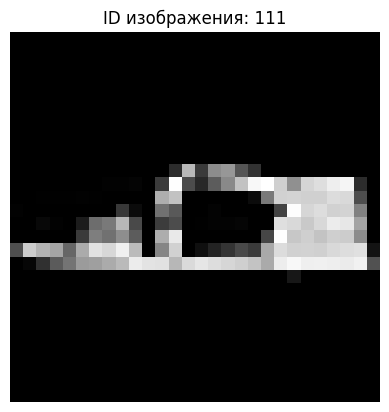

In [112]:
# Посмотрим предсказание на рандомном элементе из тестовой выборки
sample_idx = 111
plt.imshow(X_test[sample_idx].reshape(28, 28), cmap='gray')
plt.title(f"ID изображения: {sample_idx}")
plt.axis('off')
plt.show()

In [113]:
# Предсказание модели
classes[pred_classes[sample_idx]]

'Sandal'

In [99]:
# Сохраняем файл
submission2 = pd.DataFrame({
    'Id': test_df['Id'],
    'label': pred_classes
})

submission2.to_csv('submission2.csv', index=False)
print("Файл сохранен")

Файл сохранен


In [102]:
# Посмотрим, что файл в правильном формате
submission2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Id      10000 non-null  int64
 1   label   10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


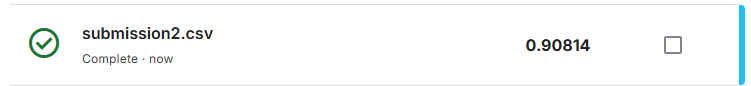

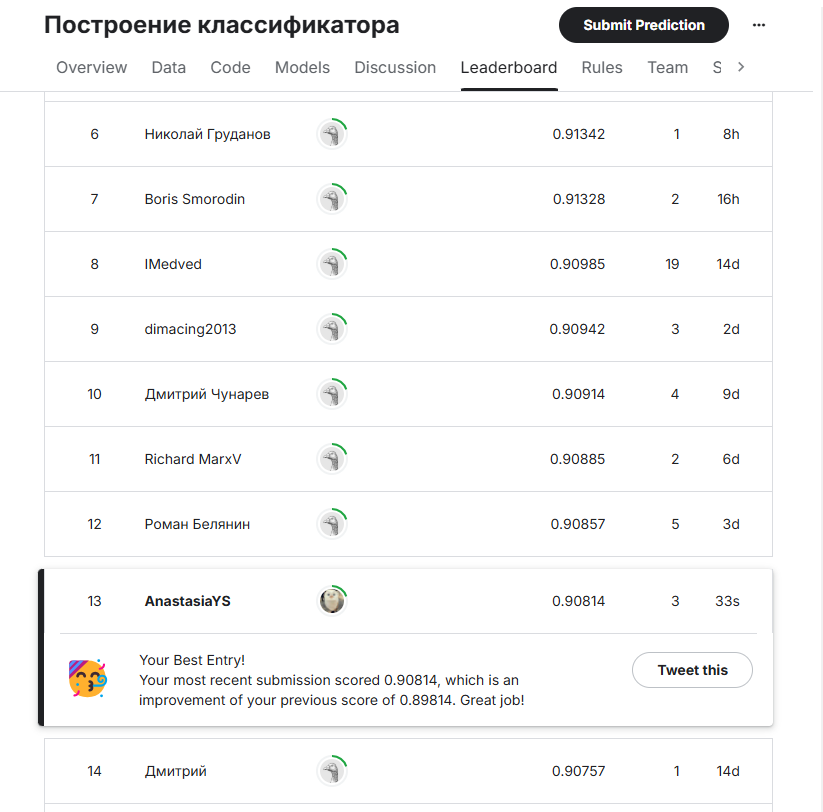